In [226]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [227]:
%matplotlib inline

import itertools
#from sessions import selected_009266, selected_008229, selected_009265, selected_57, selected_013829
from sessions_nMAP_EV_SU import selected
from imports import *
from scipy import stats
from scipy import signal
from skimage.segmentation import watershed, slic
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D

from sklearn import decomposition
#from population import unit_activity_matrix
from psth import get_psth_matrix

In [228]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [229]:
def pval2text(p_val):
    if p_val > 0.05:
        return 'n.s.'
    elif p_val > 0.01:
        return '*'
    elif p_val > 0.001:
        return '**'
    elif p_val > 0.01:
        return '***'
    else:
        return '****'

In [230]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list
all_selected[:7], len(all_selected)

(['009266_hippoSIT_2023-04-17_17-04-17',
  '009266_hippoSIT_2023-04-18_10-10-37',
  '009266_hippoSIT_2023-04-18_17-03-10',
  '009266_hippoSIT_2023-04-19_10-33-51',
  '009266_hippoSIT_2023-04-20_08-57-39',
  '009266_hippoSIT_2023-04-21_08-43-00',
  '009266_hippoSIT_2023-04-21_13-12-31'],
 68)

In [231]:
#session = '009266_hippoSIT_2023-04-18_10-10-37'  # 25 units, OK
#session = '013829_ppcSIT_2024-11-17_15-26-16'
#session = '013829_ppcSIT_2024-11-16_19-31-26'
#session = '013829_ppcSIT_2024-11-16_11-17-54'
#session = '009266_hippoSIT_2023-04-18_10-10-37'
#session = '013829_ppcSIT_2024-11-25_10-04-29'  # 37 units, OK
#session = '013829_ppcSIT_2024-11-20_09-26-11'
#session = '009265_hippoSIT_2023-03-05_18-31-32'
#session = '013829_ppcSIT_2024-11-16_11-17-54'
session = '013829_ppcSIT_2024-11-20_16-59-28'

## Multiplexing: sound, locomotion, engagement

In [232]:
animal   = session.split('_')[0]
session_path = os.path.join(source, animal, session)
#nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
bmap_file  = os.path.join(session_path, 'analysis', 'bMAP_segmentation.h5')
meta_file  = os.path.join(session_path, 'meta.h5')
desc_file  = os.path.join(session_path, 'descendants.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx = np.array(f['processed']['target_matrix'])
with h5py.File(nmap_file, 'r') as f:
    response_manifold = np.array(f['response_manifold'])
    unit_mx_ev = np.array(f['unit_mx_proc_ev'])
    unit_mx_su = np.array(f['unit_mx_proc_su'])
    
#if os.path.exists(desc_file):
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd    = np.array(f['hd'])
# else:
#     speed = tl[:, 3]
#     hd    = tl[:, 4]
    
with h5py.File(bmap_file, 'r') as f:
    idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
idxs_bU_ev = np.array([x for x in range(len(sound_events)) if not x in idxs_tgt_succ_state_ev])

fit = response_manifold  # short var name
response_manifold.shape, session

((9599, 2), '013829_ppcSIT_2024-11-20_16-59-28')

In [233]:
unit_mx_ev.shape, unit_mx_su.shape  # event sampling

((9599, 33), (9599, 33))

In [234]:
# compute event indices
speed_thresh = 0.04  # m/s

idxs_suc_ev = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_suc_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_suc_ev = np.array(idxs_suc_ev)

# auditory state (BGR, SIL etc.) and speed filter
idxs_sta_ev = np.where(speed[sound_events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
idxs_run_ev = np.where(speed[sound_events[:, 2].astype(np.int32)] > speed_thresh)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]
idxs_non_ev = np.where( (sound_events[:, 1] == 0) | (sound_events[:, 1] == 1) )[0]  # non-target

# for behavioral state
idxs_non_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_non_ev)
idxs_non_sta_bE_ev = np.intersect1d(idxs_tgt_succ_state_ev, idxs_non_sta_ev)
idxs_non_sta_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_sta_ev)
idxs_sil_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_sil_ev)

# for speed
idxs_non_run_ev    = np.intersect1d(idxs_run_ev, idxs_non_ev)
idxs_non_run_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_run_ev)
idxs_sil_bU_ev     = np.intersect1d(idxs_bU_ev, idxs_sil_ev)

In [235]:
# multiplexing events: sound, locomotion, engagement

# ------ NO STIMULUS ------

# 000: in silence, stationary non-engaged condition
idxs_000 = np.intersect1d(idxs_sta_ev, idxs_sil_ev)
idxs_000 = np.intersect1d(idxs_000, idxs_bU_ev)

# 001: in silence, stationary engaged condition
idxs_001 = np.intersect1d(idxs_sta_ev, idxs_sil_ev)
idxs_001 = np.intersect1d(idxs_001, idxs_tgt_succ_state_ev)

# 010: in silence, running non-engaged condition
idxs_010 = np.intersect1d(idxs_run_ev, idxs_sil_ev)
idxs_010 = np.intersect1d(idxs_010, idxs_bU_ev)

# 011: in silence, running engaged - should not happen!
idxs_011 = np.intersect1d(idxs_run_ev, idxs_sil_ev)
idxs_011 = np.intersect1d(idxs_011, idxs_tgt_succ_state_ev)

# ------ BGR STIMULUS ------

# 100: in trial, stationary non-engaged condition
idxs_100 = np.intersect1d(idxs_sta_ev, idxs_bgr_ev)
idxs_100 = np.intersect1d(idxs_100, idxs_bU_ev)

# 101: in trial, stationary engaged condition
idxs_101 = np.intersect1d(idxs_sta_ev, idxs_bgr_ev)
idxs_101 = np.intersect1d(idxs_101, idxs_tgt_succ_state_ev)

# 110: in trial, running non-engaged condition
idxs_110 = np.intersect1d(idxs_run_ev, idxs_bgr_ev)
idxs_110 = np.intersect1d(idxs_110, idxs_bU_ev)

# 111: in trial, running engaged - should not happen!
idxs_111 = np.intersect1d(idxs_run_ev, idxs_bgr_ev)
idxs_111 = np.intersect1d(idxs_111, idxs_tgt_succ_state_ev)

# ------ TGT STIMULUS ------

# 200: in TGT, stationary non-engaged condition
idxs_200 = np.intersect1d(idxs_sta_ev, idxs_tgt_ev)
idxs_200 = np.intersect1d(idxs_200, idxs_bU_ev)

# 201: in TGT, stationary engaged condition
idxs_201 = np.intersect1d(idxs_sta_ev, idxs_tgt_ev)
idxs_201 = np.intersect1d(idxs_201, idxs_tgt_succ_state_ev)

# 210: in TGT, running non-engaged condition
idxs_210 = np.intersect1d(idxs_run_ev, idxs_tgt_ev)
idxs_210 = np.intersect1d(idxs_210, idxs_bU_ev)

# 211: in TGT, running engaged - should not happen!
idxs_211 = np.intersect1d(idxs_run_ev, idxs_tgt_ev)
idxs_211 = np.intersect1d(idxs_211, idxs_tgt_succ_state_ev)

print('NO STIMULUS')
print(len(idxs_000), len(idxs_001), len(idxs_010), len(idxs_011))
print('BGR STIMULUS')
print(len(idxs_100), len(idxs_101), len(idxs_110), len(idxs_111))
print('TGT STIMULUS')
print(len(idxs_200), len(idxs_201), len(idxs_210), len(idxs_211))

NO STIMULUS
1077 399 2212 331
BGR STIMULUS
1264 433 2145 450
TGT STIMULUS
208 677 73 95


/tmp/ipykernel_2537791/1256366796.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


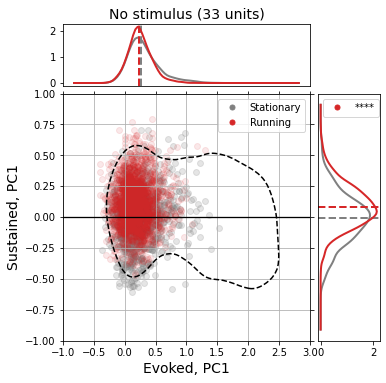

In [240]:
from matplotlib.lines import Line2D

margin = 5
sigma = 0.3
clr_scheme = custom

fig = plt.figure(figsize=(5.5, 5.5))
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, \
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# selection
#idxs_all = [idxs_sil_ev, idxs_bgr_ev, idxs_suc_ev, idxs_000, idxs_001, idxs_010]
#idxs_all = [idxs_sil_ev, idxs_bgr_ev, idxs_suc_ev, idxs_100, idxs_101, idxs_110]
#idxs_all = [idxs_sil_ev, idxs_bgr_ev, idxs_suc_ev, idxs_200, idxs_201, idxs_210]
alphas   = [0.2, 0.1, 0.1]

# No stimulus, STA, AL
idxs_all, title = [idxs_000, idxs_001], 'No stimulus'
colors   = [clr_scheme['silence'], clr_scheme['engagement']]
labels   = ['Stationary', 'Stationary, Engaged']

# No stimulus, RUN, PH
idxs_all, title = [idxs_000, idxs_010], 'No stimulus'  
colors   = [clr_scheme['silence'], clr_scheme['locomotion']]
labels   = ['Stationary', 'Running']

# # # Background, STA, AL
# idxs_all, title = [idxs_100, idxs_101], 'Background'  
# colors   = [clr_scheme['background'], clr_scheme['engagement']]
# labels   = ['Stationary', 'Stationary, engaged']

# # Background, RUN, PH
# idxs_all, title = [idxs_100, idxs_110], 'Background'  
# colors   = [clr_scheme['background'], clr_scheme['locomotion']]
# labels   = ['Stationary', 'Running']


# --------- scatter plots ---------

ax = fig.add_subplot(gs[1, 0])

legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label=labels[0]),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[1], markersize=10, label=labels[1]),
    #Line2D([0], [0], marker='.', linestyle='None', color=colors[2], markersize=10, label=labels[2]),
]

# get contours
extent = get_extent(fit, margin=margin)
d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
levels = np.linspace(0.1*d_map.max(), d_map.max(), 2)
CS_fit = ax.contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
ax.clear()

# scatter plot
for i, idxs in enumerate(idxs_all):
    ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=alphas[i], color=colors[i], label=labels[i])
    #ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, c=np.log(speed[sound_events[:, 2].astype(np.int32)]), cmap='seismic')

# regression line for no stimulus
# res = stats.linregress(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1])
# x = np.array([fit[idxs_sil_ev][:, 0].min(), 1])
# ax.plot(x, res.intercept + res.slope*x, color='black', alpha=0.8, ls='--')

# ylims
x_min, x_max = -1, 3
y_min, y_max = -1, 1
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xlabel('Evoked, PC1', fontsize=14)
ax.set_ylabel('Sustained, PC1', fontsize=14)
ax.legend(handles=legend_elements)
ax.axhline(0, color='black', lw=1.3)
#ax.axvline(0, color='black', lw=1.3)
ax.grid()

# plot contours
for path in CS_fit.collections[0].get_paths():
    verts = path.vertices
    ax.plot(verts[:,0], verts[:,1], ls='--', color='black')

# --------- evoked histograms ---------

x = np.linspace(x_min, x_max, 100)

p_val = stats.mannwhitneyu(fit[idxs_all[0]][:, 0], fit[idxs_all[1]][:, 0]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color='tab:orange', markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[0, 0])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 0])
    ax.plot(x, density(x), color=colors[i], lw=2)
    ax.axvline(np.median(fit[idxs][:, 0]), ls='--', color=colors[i], lw=2)
ax.set_xticks([])
#ax.legend(handles=legend_elements)
ax.set_title('%s (%d units)' % (title, unit_mx_ev.shape[1]), fontsize=14)

# --------- sustained histograms ---------

y = np.linspace(y_min, y_max, 100)

p_val = stats.mannwhitneyu(fit[idxs_all[0]][:, 1], fit[idxs_all[1]][:, 1]).pvalue
#p_val2 = stats.mannwhitneyu(fit[idxs_all[0]][:, 1], fit[idxs_all[2]][:, 1]).pvalue
#print(p_val1, p_val2)
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[1], markersize=10, label='%s' % pval2text(p_val)),
    #Line2D([0], [0], marker='.', linestyle='None', color=colors[2], markersize=10, label='%s' % pval2text(p_val2)),
]

ax = fig.add_subplot(gs[1, 1])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 1])
    ax.plot(density(y), y, color=colors[i], lw=2)
    ax.axhline(np.median(fit[idxs][:, 1]), ls='--', color=colors[i], lw=2)
ax.legend(handles=legend_elements)
ax.set_yticks([])

fig.tight_layout()
#fig.savefig(os.path.join(rep_path, '%s_110.png' % session[-19:-6]), dpi=300)

In [1]:
import matplotlib

print(matplotlib.colors.cnames["grey"])

for c in plt.cm.tab10.colors: 
    print(matplotlib.colors.to_hex(c))

#808080


NameError: name 'plt' is not defined

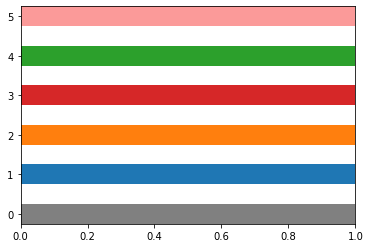

In [238]:
vibrant = {
    'silence': '#A6CEE3',  # Soft Blue
    'background': '#1F78B4',  # Teal
    'locomotion': '#FF7F00',  # Orange
    'engagement': '#6A3D9A', # Deep Purple
    'Gold': '#B15928', 
    'Coral': '#FB9A99'
}

modern  = {'Charcoal': '#2E3440', 'Deep Indigo': '#4C566A', 'Soft Cyan': '#8FBCBB', \
           'Muted Orange': '#D08770', 'Light Teal': '#81A1C1'}

nature  = {'Deep Teal': '#005F6A', 'Warm Ochre': '#D08C60', 'Forest Green': '#3B6C44',\
            'Soft Mint': '#A0DAB2', 'Pale Sand': '#F0E2B6'}

classic = {
    'silence': '#72A7CF', # Light Blue
    'background': '#1F4E79', # Dark Blue
    'locomotion': '#A43820', # Dark Red
    'engagement': '#3A772F', # Dark Green
    'Light Red': '#D16E5A', 
    'Light Green': '#89C77F'
}

custom = {
    'silence': '#808080',  # Grey
    'background': '#1f77b4',  # tab:blue
    'target': '#ff7f0e', # tab"orange
    'locomotion': '#d62728',  # tab:red
    'engagement': '#2ca02c', # tab:green
    'Coral': '#FB9A99'
}
    
fig, ax = plt.subplots()
for i, (clr_name, clr_hex) in enumerate(custom.items()):
    ax.axhline(i, color=clr_hex, lw=20)